<a href="https://colab.research.google.com/github/HSE-LAMBDA/DeepGenerativeModels/blob/master/seminars/seminar-5/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet-ml

In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="lODeHEtCf7XLaV6DJrOfugNcA",
                        project_name="hse-gans-ae", workspace="holybayes")

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid


seed=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/holybayes/hse-gans-ae/6256182115b64046b78525c20030573e



# Dataset
MNIST dataset will be used

In [2]:
batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

mnist_transforms = transforms.Compose([ 
    transforms.ToTensor(), # PIL Image -> Tensor
#     transforms.Lambda(lambda x: x/255.), # это уже сделано в мнистовом датасете
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=mnist_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=mnist_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

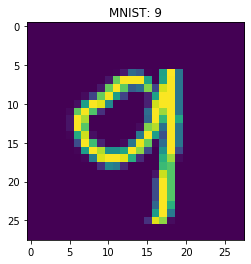

In [3]:
image, label = next(iter(train_loader))
image.shape
%matplotlib inline
import matplotlib.pyplot as plt
indx = 0
plt.title(f'MNIST: {label[indx].item()}')
plt.imshow(image[indx].squeeze(0))

## Autoencoder model

![](http://bjlkeng.github.io/images/autoencoder_structure.png)

In [4]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            # define your layers here
        )
        
        self.decoder = nn.Sequential(
            # define your layers here
        )

    def encode(self, x): # your code 
    def decode(self, z): # your code
    def forward(self, x): # your code
    def sample(self, size): # sample from z and pass through decoder
    
    @property
    def device(self): return next(self.parameters()).device


model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Train model

In [4]:
def recon_loss(recon_x, x):
    MSE = # YOUR MSE loss
    return MSE


log_interval=10
epochs=10

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # your code - сбросьте накопленный градиент
        recon_batch = # data reconstructed by your model
        loss = recon_loss(recon_batch, data)
        # your code - сделайте backprop
        train_loss += loss.item()
        # your code - сделайте градиентный шаг оптимизатором
        if batch_idx % log_interval == 0:
            experiment.log_metric('ae/train/loss', loss.item() / len(data), step=batch_idx, epoch=epoch)
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    # your code - посчитайте средний лосс на тестовой выборке
    experiment.log_metric('ae/test/loss', test_loss, epoch=epoch)

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample_size=64
        sample = model.sample(sample_size).cpu()
        log_img = make_grid(sample.view(-1,1,28,28)).permute((1,2,0))
        experiment.log_image(log_img,name='ae/sample',step=epoch)

====> Epoch: 1 Average loss: 27.8521
====> Epoch: 2 Average loss: 11.3696
====> Epoch: 3 Average loss: 9.6326
====> Epoch: 4 Average loss: 8.7514
====> Epoch: 5 Average loss: 8.1574
====> Epoch: 6 Average loss: 7.7321
====> Epoch: 7 Average loss: 7.4018
====> Epoch: 8 Average loss: 7.1234
====> Epoch: 9 Average loss: 6.8940
====> Epoch: 10 Average loss: 6.7124


# Masked Autoencoder for Distribution Estimation (MADE)

**Вопрос:** как на выходе автоэнкодера получать честные вероятности пикселей (или цветов), как в PixelCNN?

**Идея:** давайте используем тот же трюк с масками. А именно, давайте сделаем так, чтобы каждый выход $\hat{x}_i$ автоэнкодера зависел только от предыдущих входов $x_{j<i}$

![](http://bjlkeng.github.io/images/made_mask.png)

**Алгоритм MADE:**
1. Пронумеруем нейроны каждого слоя, включая входной. Нейроны входного и выходного слоя будут пронумерованы уникальными значениями от 0 (включая) до D (не включая) (D-число фичей на входе и на выходе)
2. Нейроны каждого промежуточного слоя пронумеруем НЕ ОБЯЗАТЕЛЬНО уникальными значениями из диапазона от 0 (включая) до D-1 (не включая)
3. Ограничим связи полносвязных слоёв, чтобы каждый нейрон зависел только от "предыдущих" (т.е. от нейронов с не большим индексом)
\begin{align*}
M^{W^l}_{k', k} = \left\{
            \begin{array}{ll}
              1 \text{ if } m^l(k') \geq m^{l-1}(k)  \\
              0 \text{ otherwise}
            \end{array}
          \right. \\ \tag{Inner mask}
\end{align*}

\begin{align*}
M^{V}_{d, k} = \left\{
            \begin{array}{ll}
              1 \text{ if } d > m^{L}(k)  \\
              0 \text{ otherwise}
            \end{array}
          \right.  \\ \tag{Output mask}
\end{align*}
4. Останется наложить маски матрицы весов (т.е. ограничить нейронные связи) и взять сигмоиду от выхода. Это и будут ***честные обусловленные вероятности***

\begin{align*}
{\bf h}({\bf x}) &= {\bf g}({\bf b} + {\bf (W \odot M^W)x}) \\
{\hat{\bf x}} &= \text{sigm}({\bf c} + {\bf (V \odot M^V)h(x)})  \tag{Output}
\end{align*}

In [49]:
"""
Implements Masked AutoEncoder for Density Estimation, by Germain et al. 2015
Re-implementation by Andrej Karpathy based on https://arxiv.org/abs/1502.03509
"""

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F



class MaskedLinear(nn.Linear):
    """ Такой же полносвязный слой, как дефолтный, только на веса накладываются маски """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        masked_weight = ???
        return F.linear(input, masked_weight, self.bias)

    
class MADE(nn.Module):
    def __init__(self, input_size, hidden_sizes_encoder, hidden_sizes_decoder, output_size, 
                 num_masks=1, natural_ordering=False):
        """
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes_encoder = hidden_sizes_encoder
        self.hidden_sizes_decoder = hidden_sizes_decoder
        assert self.output_size % self.input_size == 0, "nout must be integer multiple of nin"
        
        self.encoder = ??? Your code
        self.decoder = ??? Your code
                
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        # задайте маски для весов энкодера и декодера. Формула выше
        ??? Your code

    def forward(self, x):
        x = x.view(-1,784)
        return self.decoder(self.encoder(x))
    
    def sample(self, size):
        hidden_dim = self.hidden_sizes_decoder[0]
        device = next(model.parameters()).device
        x = torch.rand((size,hidden_dim)).to(device)
        return F.sigmoid(self.decoder(x))
    
model = MADE(784, [400,20], [20,400], 784)
model.to(device)

MADE(
  (encoder): Sequential(
    (0): MaskedLinear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=400, out_features=20, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): MaskedLinear(in_features=20, out_features=400, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=400, out_features=784, bias=True)
  )
)

In [55]:
# Your code - обучение то же самое, что и с обычным автоэнкодером. Только замените лосс на кросс-энтропию 

====> Epoch: 1 Average loss: 191.9323
====> Epoch: 2 Average loss: 140.1041
====> Epoch: 3 Average loss: 121.8988
====> Epoch: 4 Average loss: 115.4033
====> Epoch: 5 Average loss: 112.4706
====> Epoch: 6 Average loss: 110.3260
====> Epoch: 7 Average loss: 107.4999
====> Epoch: 8 Average loss: 104.3590
====> Epoch: 9 Average loss: 102.1362
====> Epoch: 10 Average loss: 99.4987


# Links

[simple explanation of MADE and AE](http://bjlkeng.github.io/posts/autoregressive-autoencoders/)